In [1]:
'''Importing necessary classes
'''
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os 
import math 

#os.chdir(os.getcwd() + '/camera_cal/' )

'''Loading images using glob API, converting to grayscale 
and finding corners in all images and returning image 
points and object points 
'''
def load_testImages(ncx,ncy):
    
    images = glob.glob('calibration*.jpg')
    print('Size of input calibraion images list is ',len(images))
    image_list = []
    image_gray = [] 
    objpts = []
    imgpts = []
    obj = np.zeros((ncx*ncy,3), np.float32)
    obj[:,:2] = np.mgrid[0:ncx,0:ncy].T.reshape(-1,2) 
    
    for fname in images:    
        image = mpimg.imread(fname)
        image_list.append(image)
        gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        image_gray.append(gray)
        ret,corners = cv2.findChessboardCorners(gray,(ncx,ncy),None)
    
        if ret == True:
            objpts.append(obj)
            imgpts.append(corners)
    return objpts,imgpts,image_list,image_gray


def camera_calibration(objpts,imgpts,shape):
    ret,mat,dist,rv,lv = cv2.calibrateCamera(objpts,imgpts,shape,None,None)
    return ret,mat,dist,rv,lv

def undistort_image(img,mat,dist):
    undist = cv2.undistort(img,mat,dist,None,mat)
    return undist

def binary_gradient(img,clr_thresh,gradient_thresh,sobel_kernel):
    color1_up = clr_thresh[1]
    color1_down = clr_thresh[0]
    #color2_up = clr_thresh[3]
    #color2_down = clr_thresh[2]
    grad_up = gradient_thresh[1]
    grad_down = gradient_thresh[0]
    gradient_high = gradient_thresh[3]
    gradient_low = gradient_thresh[2]
    imshape = img.shape
    image2 = np.copy(img)
    image1 = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    binary_hls  = np.zeros([imshape[0],imshape[1]])
    luv_image = cv2.cvtColor(image2,cv2.COLOR_RGB2Luv)
    l_mask = luv_image[:,:,0]
    l_binary = np.zeros([imshape[0],imshape[1]])
    l_binary[(l_mask<255) & (l_mask>225)] = 255
    
    lab_image = cv2.cvtColor(image2,cv2.COLOR_RGB2Lab)
    lab_mask = lab_image[:,:,0]
    lab_binary = np.zeros([imshape[0],imshape[1]])
    lab_binary[(lab_mask<255) & (lab_mask>200)] = 255
    
    
    #binary_white = np.zeros([imshape[0],imshape[1]])
    #mask1 = cv2.inRange(image1,color1_down,color1_up)
    #mask2 = cv2.inRange(image1,color2_down,color2_up)
    s_channel = image1[:,:,2]
    binary_hls[(s_channel<color1_up) & (s_channel>color1_down)] = 255
    #binary_white[mask2.nonzero()] = 255
    #cbinary = cv2.bitwise_or(binary_white,binary_hls)
    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    sobel_mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    sobel_mag = np.uint8(255*sobel_mag/np.max(sobel_mag))
    abs_x = np.absolute(sobelx)
    abs_y = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad = np.arctan2(abs_y, abs_x)
    
    
    sbinary = np.zeros([imshape[0],imshape[1]])
    sbinary[(sobel_mag<=grad_up) & (sobel_mag>=grad_down) & (grad<gradient_high) & (grad>gradient_low)] = 255
    bimg = np.zeros([imshape[0],imshape[1]])
    #binary = np.dstack(( np.zeros_like(sbinary), sbinary, binary_hls)) #binary = np.dstack((sbinary,binary_hls,bimg))
    #binary = cv2.bitwise_or(sbinary,binary_hls)
    
    binary = cv2.bitwise_or(sbinary,l_binary)
   # binary = cv2.bitwise_or(binary,binary_hls)
    binary = cv2.bitwise_or(binary,lab_binary)
        
    #binary = np.dstack((binary1,np.zeros_like(sbinary),np.zeros_like(sbinary)))
    #plt.imshow(sbinary,cmap='gray')
    #plt.imshow(binary_hls,cmap='gray')
    #plt.imshow(binary)
    return binary

def lane_recognition(binary_warped,nwindows,margin,minipix,imshape):
    nonzeroy = np.array(binary_warped.nonzero()[0])
    nonzerox = np.array(binary_warped.nonzero()[1])
    hist = np.sum(binary_warped,axis = 0)
    left_inds = []
    right_inds = []
    #plt.plot(hist)
    centerx = int(imshape[0]/2)
    current_basel  = np.argmax(hist[0:centerx])
    current_baser  = np.argmax(hist[centerx:]) + centerx
    init_basel = current_basel
    init_baser = current_baser
    window_height = np.int(imshape[1]//nwindows)

    print('Initial box centers are ',current_basel,current_baser,centerx)

    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) #np.copy(binary_warped) #
    #plt.imshow(binary_warped,cmap='gray')
    #plt.imshow(out_img)
    print('This is the size of the dstack image ',out_img.shape)
    for window in range(nwindows) :

        ylow = imshape[1]- window*window_height
        yhigh = imshape[1]- (window+1)*window_height
        xlow_left = current_basel - margin
        xhigh_left = current_basel + margin
        xlow_right = current_baser - margin
        xhigh_right = current_baser + margin

        indsl = ((nonzerox<=xhigh_left) & (nonzerox>=xlow_left) & (nonzeroy>=yhigh) &(nonzeroy<=ylow)).nonzero()[0]
        indsr = ((nonzerox<=xhigh_right) & (nonzerox>=xlow_right) & (nonzeroy>=yhigh) &(nonzeroy<=ylow)).nonzero()[0]
        cv2.rectangle(out_img,(xlow_left,ylow),
        (xhigh_left,yhigh),(0,255,0), 2) 
        cv2.rectangle(out_img,(xlow_right,ylow),
        (xhigh_right,yhigh),(0,255,0), 2) 

        if(len(indsl)>minipix):
            current_basel = int(np.mean(nonzerox[indsl]))
        if(len(indsr)>minipix):
            current_baser = int(np.mean(nonzerox[indsr]))

        left_inds.append(indsl)
        right_inds.append(indsr)
        
    left_inds = np.concatenate(left_inds)
    right_inds = np.concatenate(right_inds)

    leftx = nonzerox[left_inds]
    lefty = nonzeroy[left_inds]
    rightx = nonzerox[right_inds]
    righty = nonzeroy[right_inds]
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    #plt.imshow(out_img)
    return leftx,lefty,rightx,righty,out_img,init_basel,init_baser
   
def polynomial_fitting(leftx,lefty,rightx,righty,ploty,xm_per_pix,ym_per_pix):
    plotym = ploty*ym_per_pix
    leftym = lefty*ym_per_pix
    rightxm = rightx*xm_per_pix
    leftxm = leftx*xm_per_pix
    rightym = righty*ym_per_pix
    
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    left_fitm = np.polyfit(leftym,leftxm,2)
    right_fitm = np.polyfit(rightym,rightxm,2)
    
    try: 
        poly_left = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        poly_right = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        poly_leftm = left_fitm[0]*plotym**2 + left_fitm[1]*plotym + left_fitm[2]
        poly_rightm = right_fitm[0]*plotym**2 + right_fitm[1]*plotym + right_fitm[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        poly_left = 1*ploty**2 + 1*ploty
        poly_right = 1*ploty**2 + 1*ploty
        poly_leftm = 1*plotym**2 + 1*plotym
        poly_rightm = 1*plotym**2 + 1*plotym
        
        
    return poly_left,poly_right,poly_leftm,poly_rightm,left_fit,right_fit,left_fitm,right_fitm

def curvature_finding(ploty,poly_left,poly_right):
    y_eval = np.max(ploty)
    left_curverad = ((1+(2*poly_left[0]*y_eval + poly_left[1])**2)**(3/2))/(2*poly_left[0])
    right_curverad = ((1+(2*poly_right[0]*y_eval + poly_right[1])**2)**(3/2))/(2*poly_right[0]) 
    
    #ploty1 = ploty*ym_per_pix
    #leftx1 = leftx*xm_per_pix
    #rightx1 = rightx*xm_per_pix
    #lefty1 = lefty*ym_per_pix
    #righty1 = righty*ym_per_pix
    #left_fit_cr = np.polyfit(lefty1, leftx1, 2)
    #right_fit_cr = np.polyfit(righty1, rightx1, 2)

    #y_eval = np.max(ploty1)
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    #left_curveradm = ((1+(2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**(3/2))/(2*left_fit_cr[0])#0  ## Implement the calculation of the left line here
    #right_curveradm = ((1+(2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**(3/2))/(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    #print('Left and Right radii of curvature in metres are ',left_curveradm, right_curveradm)
    return left_curverad,right_curverad

def unwarp_image(binary_warped,Minv,imshape):
    unwarped = cv2.warpPerspective(binary_warped,Minv,imshape,None)
    return unwarped

class Lane_data():
    pass

Size of input calibraion images list is  20
20 20
(720, 1280, 3)
this is the size of binary warped image (720, 1280)
Initial box centers are  212 1114 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  -4097.15436961 -7382.75672841
Left and Right radii of curvature in meters are  -1793.32025171 -3351.18782517
[[ -7.11111111e-01  -1.51440329e+00   1.09037037e+03]
 [ -4.88498131e-15  -1.89629630e+00   8.53333333e+02]
 [ -8.02309608e-18  -2.37654321e-03   1.00000000e+00]]
[[  9.76562500e-02  -7.98611111e-01   5.75000000e+02]
 [  8.88178420e-15  -5.27343750e-01   4.50000000e+02]
 [  1.77809156e-17  -1.25325521e-03   1.00000000e+00]]


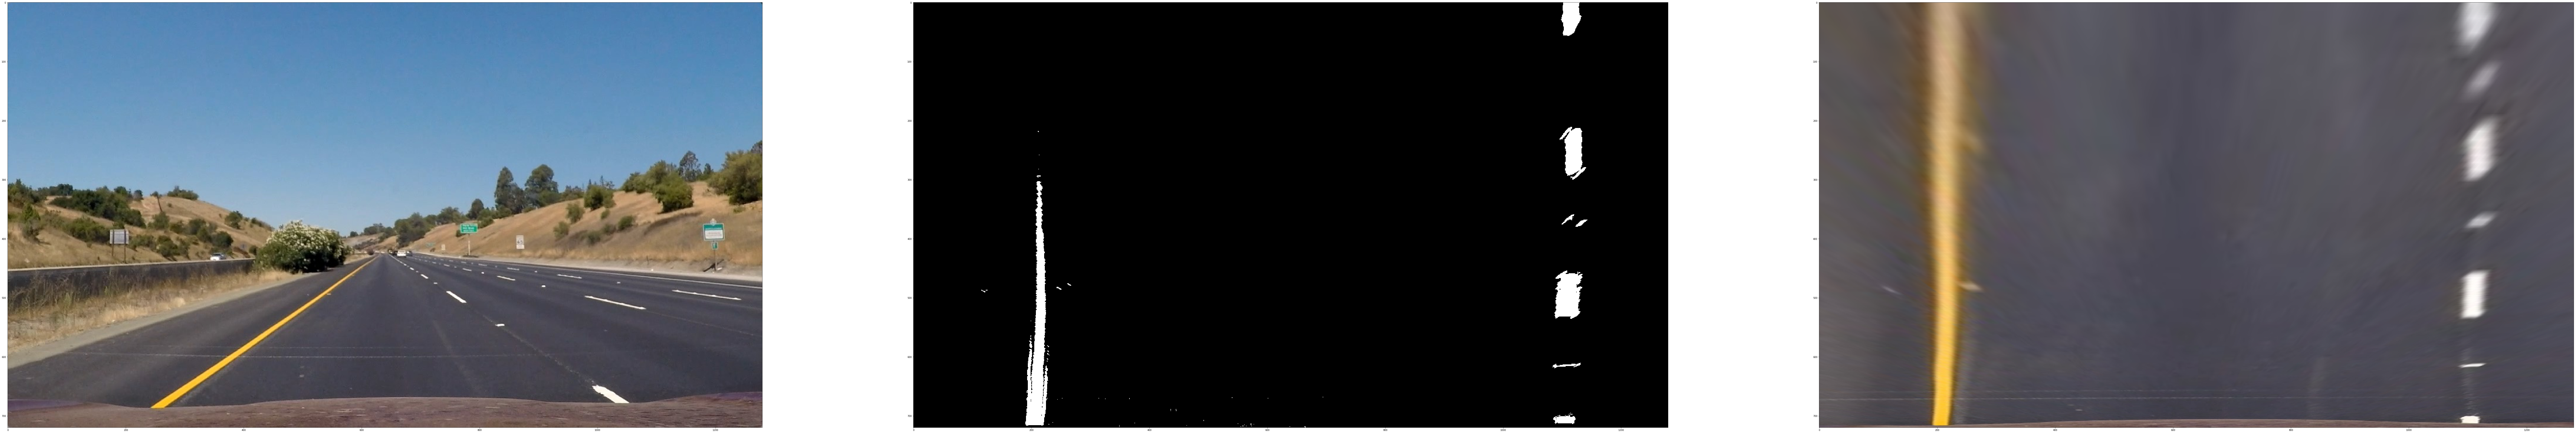

In [2]:
from PIL import Image, ImageDraw,ImageFont

ncx = 9
ncy = 6 #no. of corners in the y direction 
os.chdir('camera_cal/' )
objpts,imgpts,image_list,image_gray = load_testImages(ncx,ncy)

#Calibrating the camera and returning the distrotion matrices
print(len(image_gray),len(image_list))
shape = image_gray[0].shape[::-1]
ret,mat,dist,rv,lv = camera_calibration(objpts,imgpts,shape)

image_undist = []
for i in range(len(image_list)):
    image_undist.append(undistort_image(image_list[i],mat,dist))
mpimg.imsave('../output_images/Original_chessboard.jpg',image_list[1])
mpimg.imsave('../output_images/Undistorted_chessboard.jpg',image_undist[1])
####################################################################
testing = glob.glob('../test_images/*.jpg')
test_images = []
test_images_gray = []
undist_images = []

for images in testing :
    image = mpimg.imread(images)
    undistimage = undistort_image(image,mat,dist)
    undist_images.append(undistimage)
    test_images.append(image)
    gray_image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    test_images_gray.append(gray_image)
mpimg.imsave('../output_images/original_test.jpg',test_images[1])
mpimg.imsave('../output_images/undistorted_test.jpg',undist_images[1])

image_index = 5
imshape  = test_images_gray[image_index].shape

src =  np.float32([[100,imshape[0]],[575,450],[700,450],[1180,imshape[0]]])    #current? 
dst = np.float32([[100,imshape[0]],[0,0],[imshape[1],0],[1180,imshape[0]]])


#src =  np.float32([[100,imshape[0]],[530,470],[750,470],[1180,imshape[0]]])    #best so far? 
#dst = np.float32([[100,imshape[0]],[0,0],[imshape[1],0],[1180,imshape[0]]])

#src =  np.float32([[80,imshape[0]],[490,490],[790,490],[1200,imshape[0]]])  #sort of working but large curvature
#dst = np.float32([[80,imshape[0]],[0,0],[imshape[1],0],[1200,imshape[0]]])


#src =  np.float32([[80,imshape[0]],[490,490],[790,490],[1200,imshape[0]]])
#dst = np.float32([[80,imshape[0]],[80,0],[1200,0],[1200,imshape[0]]])

#src =  np.float32([[60,imshape[0]],[520,450],[760,450],[1220,imshape[0]]])
#dst = np.float32([[60,imshape[0]],[60,0],[1220,0],[1220,imshape[0]]])


M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst,src)

new_img = cv2.warpPerspective(undist_images[image_index],M,(imshape[1],imshape[0]))
##new_img  is the warped image after gradient application
print(new_img.shape)
#plt.imshow(new_img)

clr_thresh = []
clr_thresh.append(150)   #color thresholds
clr_thresh.append(255)

gradient_thresh = []
gradient_thresh.append([30])
gradient_thresh.append([200])
gradient_thresh.append([-1.3])
gradient_thresh.append([1.3])

sobel_kernel = 3

img = test_images[image_index]
#imshape = (img.shape[1],img.shape[0])

binary_image = binary_gradient(new_img,clr_thresh,gradient_thresh,sobel_kernel)
#binary_image = warped 1 layer
#binary_warped1 = cv2.warpPerspective(binary_image,M,imshape)
#mpimg.imsave('../output_images/undistorted_nograds.jpg',img)
#mpimg.imsave('../output_images/binary_gradsandcolors.jpg',binary_image,cmap='gray')
mpimg.imsave('../output_images/warped_nograds.jpg',new_img)
mpimg.imsave('../output_images/warped_binary.jpg',binary_image,cmap='gray')

#plt.imshow(binary_image, cmap='gray')
print('this is the size of binary warped image',binary_image.shape)
f,ax = plt.subplots(1,3,figsize=(200,100))
ax[0].imshow(img)
ax[1].imshow(binary_image, cmap='gray')
ax[2].imshow(new_img)
#ax[3].imshow(binary_warped1, cmap='gray')


binary_warped = np.copy(binary_image)

nwindows = 12
#window_height = int(imshape[1]//nwindows)
margin = 100
minipix = 50

#out_img = np.copy(binary_warped) #np.dstack((binary_warped, binary_warped, binary_warped))
#plt.imshow(binary_warped,cmap='gray')
#plt.imshow(out_img)
#plt.imshow(binary_warped,cmap='gray')
leftx,lefty,rightx,righty,out_img,init_basel,init_baser = lane_recognition(binary_warped,nwindows,margin,minipix,(imshape[1],imshape[0]))
#mpimg.imsave('../output_images/out_img_with_lines.jpg',out_img)

ploty = np.linspace(0,imshape[1]-1,imshape[1])
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/1000 # meters per pixel in x dimension
poly_left,poly_right,poly_leftm,poly_rightm,left_fit,right_fit,left_fitm,right_fitm = polynomial_fitting(leftx,lefty,rightx,righty,ploty,xm_per_pix,ym_per_pix)

plotym = ploty*ym_per_pix
left_curverad,right_curverad = curvature_finding(ploty,left_fit,right_fit)
print('Left and Right radii of curvature in pixels are ',left_curverad, right_curverad)
left_curveradm,right_curveradm = curvature_finding(plotym,left_fitm,right_fitm)
print('Left and Right radii of curvature in meters are ',left_curveradm, right_curveradm)



warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
pts_left = np.array([np.transpose(np.vstack([poly_left, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([poly_right, ploty])))])
pts = np.hstack((pts_left, pts_right))
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (test_images[image_index].shape[1],test_images[image_index].shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist_images[image_index], 1, newwarp, 0.3, 0)

#####################Text to write on image######################
radius_mag = 0.5*(np.absolute(left_curveradm)+ np.absolute(right_curveradm))
end_y = image.shape[0]*ym_per_pix
left_lanex = left_fitm[0]*end_y**2  + left_fitm[1]*end_y + left_fitm[2]
right_lanex = right_fitm[0]*end_y**2  + right_fitm[1]*end_y + right_fitm[2]
car_gap = round((0.5*(left_lanex+right_lanex) - image.shape[1]*xm_per_pix/2),2)

if(car_gap> 0):
    side_car = 'The vehicle is ' + str(car_gap) + ' m to the left of center '
elif(car_gap<0):
    side_car = 'The vehicle is ' + str(-car_gap) + ' m to the lright of center '
else:
    side_car = 'The vehicle is at the center '

radius_text = 'Radius of curvature is ' + str(np.int(radius_mag)) + ' (m)'

#print(os.getcwd())
os.chdir('..')
font_type = ImageFont.truetype("arial.ttf", 40, encoding="unic")
#####################Text to write on image######################

#print(end_y,left_lanex,right_lanex,car_gap,side_car)
#font_type  = ImageFont.truetype("arial.ttf", 15)

result1 = np.copy(result)
result = Image.fromarray(result) 
draw = ImageDraw.Draw(result)
draw.text(xy=(0,0),text = radius_text,fill = (255,0,0),font = font_type)
draw.text(xy=(0,40),text = side_car,fill = (255,0,0),font = font_type)
#mpimg.imsave('output_images/final_output.jpg',result)    
    
#plt.imshow(result)


#plt.plot(poly_left,  ploty,color='yellow')
#plt.plot(poly_right,  ploty,color='yellow')
#plt.imshow(out_img)
#plt.imshow(out_img,cmap='gray')
unwarped_image = unwarp_image(out_img,Minv,(imshape[1],imshape[0]))
#plt.show()
#plt.imshow(unwarped_image)
#mpimg.imsave('../output_images/unwarped_binary.jpg',unwarped_image[:,:,:]/(max(unwarped_image[:,:,:])))

print(M)
#print('lol')
print(Minv)
#print(mat)
#print(dist)

In [3]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from PIL import Image, ImageDraw,ImageFont


def process_image(image):
 
    #M = cv2.getPerspectiveTransform(src,dst)
    #Minv = cv2.getPerspectiveTransform(dst,src)
    M = np.array([[ -7.74038462e-01,  -1.57692308e+00,   1.13538462e+03],
                 [ -1.66533454e-15,  -2.42307692e+00,   1.18730769e+03],         #old 
                 [ -2.43945489e-18,  -2.46394231e-03,   1.00000000e+00]])
    
    M = np.array([[ -7.11111111e-01,  -1.51440329e+00,   1.09037037e+03],
                 [ -4.88498131e-15,  -1.89629630e+00,   8.53333333e+02],
                 [ -8.02309608e-18,  -2.37654321e-03,   1.00000000e+00]])
    
    
    Minv = np.array([[  2.67857143e-01,  -6.50793651e-01,   4.68571429e+02],
                     [  1.15463195e-14,  -4.12698413e-01,   4.90000000e+02],    #old
                     [  1.90819582e-17,  -1.01686508e-03,   1.00000000e+00]])
    
    Minv = np.array([[  9.76562500e-02,  -7.98611111e-01,   5.75000000e+02],
                     [  8.88178420e-15,  -5.27343750e-01,   4.50000000e+02],
                     [  1.77809156e-17,  -1.25325521e-03,   1.00000000e+00]])

    
    mat = np.array([[  1.15777818e+03,   0.00000000e+00,   6.67113857e+02],
                     [  0.00000000e+00,   1.15282217e+03,   3.86124583e+02],
                     [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])
    dist = np.array([[-0.24688507, -0.02373155, -0.00109831,  0.00035107, -0.00259867]])
    
    undistimage = undistort_image(image,mat,dist)
    #print(mat,'This is the mat matrix') 
    #print(dist,'This is the dist matrix') 
    
    new_img = cv2.warpPerspective(undistimage,M,(imshape[1],imshape[0]))

    clr_thresh = []
    clr_thresh.append(50)   #color thresholds
    clr_thresh.append(255)

    gradient_thresh = []
    gradient_thresh.append([30])
    gradient_thresh.append([255])
    gradient_thresh.append([-1.3])
    gradient_thresh.append([1.3])

    sobel_kernel = 3

    binary_image = binary_gradient(new_img,clr_thresh,gradient_thresh,sobel_kernel)

    print('this is the size of binary warped image',binary_image.shape)
    binary_warped = np.copy(binary_image)

    nwindows = 12
    margin = 100
    minipix = 50

    #plt.imshow(binary_warped,cmap='gray')

    leftx,lefty,rightx,righty,out_img,init_basel,init_baser = lane_recognition(binary_warped,nwindows,margin,minipix,(imshape[1],imshape[0]))

    ploty = np.linspace(0,imshape[1]-1,imshape[1])
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/1000 # meters per pixel in x dimension
    poly_left,poly_right,poly_leftm,poly_rightm,left_fit,right_fit,left_fitm,right_fitm = polynomial_fitting(leftx,lefty,rightx,righty,ploty,xm_per_pix,ym_per_pix)
    plotym = ploty*ym_per_pix
    left_curverad,right_curverad = curvature_finding(ploty,left_fit,right_fit)
    print('Left and Right radii of curvature in pixels are ',left_curverad, right_curverad)
    left_curveradm,right_curveradm = curvature_finding(plotym,left_fitm,right_fitm)
    print('Left and Right radii of curvature in meters are ',left_curveradm, right_curveradm)
    
    unwarped_image = unwarp_image(out_img,Minv,(imshape[1],imshape[0]))
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([poly_left, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([poly_right, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (test_images[image_index].shape[1],test_images[image_index].shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    #####################Text to write on image######################
    radius_mag = 0.5*(np.absolute(left_curveradm)+ np.absolute(right_curveradm))
    end_y = image.shape[0]*ym_per_pix
    left_lanex = left_fitm[0]*end_y**2  + left_fitm[1]*end_y + left_fitm[2]
    right_lanex = right_fitm[0]*end_y**2  + right_fitm[1]*end_y + right_fitm[2]
    car_gap = round((0.5*(left_lanex+right_lanex) - image.shape[1]*xm_per_pix/2),2)

    if(car_gap> 0):
        side_car = 'The vehicle is ' + str(car_gap) + ' m to the left of center '
    elif(car_gap<0):
        side_car = 'The vehicle is ' + str(-car_gap) + ' m to the lright of center '
    else:
        side_car = 'The vehicle is at the center '

    radius_text = 'Radius of curvature is ' + str(np.int(radius_mag)) + ' (m)'

    print(os.getcwd())
    #os.chdir('..')
    font_type = ImageFont.truetype("arial.ttf", 40, encoding="unic")
    print(end_y,left_lanex,right_lanex,car_gap,side_car)
    #####################Text to write on image######################
    result1 = np.copy(result)
    result = Image.fromarray(result) 
    draw = ImageDraw.Draw(result)
    draw.text(xy=(0,0),text = radius_text,fill = (255,0,0),font=font_type)
    draw.text(xy=(0,40),text = side_car,fill = (255,0,0),font=font_type)
    return np.asarray( result, dtype="int32" )




In [4]:
#print(os.getcwd())
#os.chdir('..')
white_output = 'output_images/testing_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(2,5)

clip1 = VideoFileClip("project_video.mp4").subclip(29,30)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.ipython_display
%time white_clip.write_videofile(white_output, audio=False)

this is the size of binary warped image (720, 1280)
Initial box centers are  275 1199 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  3523.8832362 2702.70551394
Left and Right radii of curvature in meters are  1636.07315425 1183.08720455
/home/workspace/CarND-Advanced-Lane-Lines
30.0 0.962092031841 4.28727511906 0.26 The vehicle is 0.26 m to the left of center 
[MoviePy] >>>> Building video output_images/testing_video.mp4
[MoviePy] Writing video output_images/testing_video.mp4


  0%|          | 0/26 [00:00<?, ?it/s]

this is the size of binary warped image (720, 1280)


  4%|▍         | 1/26 [00:00<00:07,  3.22it/s]

Initial box centers are  275 1199 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  3523.8832362 2702.70551394
Left and Right radii of curvature in meters are  1636.07315425 1183.08720455
/home/workspace/CarND-Advanced-Lane-Lines
30.0 0.962092031841 4.28727511906 0.26 The vehicle is 0.26 m to the left of center 


  8%|▊         | 2/26 [00:00<00:07,  3.18it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  277 1200 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  3418.31949229 2984.63826392
Left and Right radii of curvature in meters are  1585.72043506 1334.87620792
/home/workspace/CarND-Advanced-Lane-Lines
30.0 0.964991208068 4.28996599764 0.26 The vehicle is 0.26 m to the left of center 


 12%|█▏        | 3/26 [00:00<00:07,  3.19it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  281 1192 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  3693.44926804 2387.68266682
Left and Right radii of curvature in meters are  1720.23478596 981.676744179
/home/workspace/CarND-Advanced-Lane-Lines
30.0 0.975631881733 4.33557215988 0.29 The vehicle is 0.29 m to the left of center 


 15%|█▌        | 4/26 [00:01<00:06,  3.22it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  281 1187 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  3408.69375756 2882.43147426
Left and Right radii of curvature in meters are  1583.19437722 1272.22834658
/home/workspace/CarND-Advanced-Lane-Lines
30.0 0.976468547325 4.31512869156 0.28 The vehicle is 0.28 m to the left of center 


 19%|█▉        | 5/26 [00:01<00:06,  3.23it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  281 1188 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  3405.44754814 3789.25970216
Left and Right radii of curvature in meters are  1581.84361871 1747.16104113
/home/workspace/CarND-Advanced-Lane-Lines
30.0 0.981833645063 4.29725819032 0.27 The vehicle is 0.27 m to the left of center 


 23%|██▎       | 6/26 [00:01<00:06,  3.26it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  284 1179 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  3224.00227728 3785.54552287
Left and Right radii of curvature in meters are  1493.60537982 1742.4559693
/home/workspace/CarND-Advanced-Lane-Lines
30.0 0.991745301049 4.29956320154 0.28 The vehicle is 0.28 m to the left of center 


 27%|██▋       | 7/26 [00:02<00:05,  3.27it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  283 1184 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  3090.19727436 4183.1015624
Left and Right radii of curvature in meters are  1430.52689051 1937.29485415
/home/workspace/CarND-Advanced-Lane-Lines
30.0 0.997970400326 4.28911757708 0.28 The vehicle is 0.28 m to the left of center 


 31%|███       | 8/26 [00:02<00:05,  3.26it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  289 1180 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  2816.06995274 3012.70886509
Left and Right radii of curvature in meters are  1289.35890547 1325.9481698
/home/workspace/CarND-Advanced-Lane-Lines
30.0 1.02010680625 4.31909760658 0.3 The vehicle is 0.3 m to the left of center 


 35%|███▍      | 9/26 [00:02<00:05,  3.22it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  290 1175 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  2541.72718058 4501.67158374
Left and Right radii of curvature in meters are  1148.31579081 2089.41178695
/home/workspace/CarND-Advanced-Lane-Lines
30.0 1.02010455647 4.2911380631 0.29 The vehicle is 0.29 m to the left of center 


 38%|███▊      | 10/26 [00:03<00:04,  3.21it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  291 1181 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  2519.27373446 5852.07617998
Left and Right radii of curvature in meters are  1136.42647723 2740.24634615
/home/workspace/CarND-Advanced-Lane-Lines
30.0 1.02016830983 4.29089294597 0.29 The vehicle is 0.29 m to the left of center 


 42%|████▏     | 11/26 [00:03<00:04,  3.21it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  291 1180 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  2448.3774354 5262.05746174
Left and Right radii of curvature in meters are  1099.00722342 2456.66290093
/home/workspace/CarND-Advanced-Lane-Lines
30.0 1.02576441196 4.30026322401 0.3 The vehicle is 0.3 m to the left of center 


 46%|████▌     | 12/26 [00:03<00:04,  3.17it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  293 1209 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  2463.42813218 6388.62415392
Left and Right radii of curvature in meters are  1106.09579185 2994.12135551
/home/workspace/CarND-Advanced-Lane-Lines
30.0 1.02882165395 4.30200673819 0.3 The vehicle is 0.3 m to the left of center 


 50%|█████     | 13/26 [00:04<00:04,  3.17it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  293 1202 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  2452.38545422 9280.39319582
Left and Right radii of curvature in meters are  1103.51344525 4354.41405931
/home/workspace/CarND-Advanced-Lane-Lines
30.0 1.03370376821 4.30480534097 0.3 The vehicle is 0.3 m to the left of center 


 54%|█████▍    | 14/26 [00:04<00:03,  3.16it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  291 1203 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  2457.14986381 6957.04962044
Left and Right radii of curvature in meters are  1103.65237619 3261.79820086
/home/workspace/CarND-Advanced-Lane-Lines
30.0 1.03558433237 4.3143042037 0.31 The vehicle is 0.31 m to the left of center 


 58%|█████▊    | 15/26 [00:04<00:03,  3.16it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  295 1198 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  2297.86799731 2702.67046816
Left and Right radii of curvature in meters are  1016.88451649 1142.24166182
/home/workspace/CarND-Advanced-Lane-Lines
30.0 1.05168263566 4.36538317899 0.34 The vehicle is 0.34 m to the left of center 


 62%|██████▏   | 16/26 [00:05<00:03,  3.14it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  295 1199 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  2534.19598559 3249.42403402
Left and Right radii of curvature in meters are  1151.72189785 1451.21621661
/home/workspace/CarND-Advanced-Lane-Lines
30.0 1.04057720891 4.33781749783 0.32 The vehicle is 0.32 m to the left of center 


 65%|██████▌   | 17/26 [00:05<00:02,  3.12it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  298 1195 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  2706.21699171 3248.98823516
Left and Right radii of curvature in meters are  1245.88404333 1447.40713211
/home/workspace/CarND-Advanced-Lane-Lines
30.0 1.04132602783 4.33719620398 0.32 The vehicle is 0.32 m to the left of center 


 69%|██████▉   | 18/26 [00:05<00:02,  3.07it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  299 1189 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  2689.86216005 3120.40789065
Left and Right radii of curvature in meters are  1237.00271126 1379.84939374
/home/workspace/CarND-Advanced-Lane-Lines
30.0 1.0495240284 4.33849201615 0.33 The vehicle is 0.33 m to the left of center 


 73%|███████▎  | 19/26 [00:06<00:02,  3.04it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  301 1189 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  2728.08771578 3131.61624401
Left and Right radii of curvature in meters are  1258.46099926 1387.51766941
/home/workspace/CarND-Advanced-Lane-Lines
30.0 1.05265579354 4.33207879172 0.32 The vehicle is 0.32 m to the left of center 


 77%|███████▋  | 20/26 [00:06<00:01,  3.02it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  302 1186 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  2424.57226695 2604.8111008
Left and Right radii of curvature in meters are  1089.02566708 1091.58429611
/home/workspace/CarND-Advanced-Lane-Lines
30.0 1.08029659328 4.35815829288 0.35 The vehicle is 0.35 m to the left of center 


 81%|████████  | 21/26 [00:06<00:01,  2.99it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  302 1184 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  2775.79000825 3111.09711687
Left and Right radii of curvature in meters are  1277.57645084 1385.69966964
/home/workspace/CarND-Advanced-Lane-Lines
30.0 1.06626316531 4.34167682414 0.34 The vehicle is 0.34 m to the left of center 


 85%|████████▍ | 22/26 [00:07<00:01,  2.99it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  304 1188 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  2953.92107972 3167.11936021
Left and Right radii of curvature in meters are  1368.2944291 1418.3270983
/home/workspace/CarND-Advanced-Lane-Lines
30.0 1.06723702998 4.34922576308 0.34 The vehicle is 0.34 m to the left of center 


 88%|████████▊ | 23/26 [00:07<00:01,  2.99it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  305 1189 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  3209.98133779 3616.92796111
Left and Right radii of curvature in meters are  1495.11125811 1655.44817975
/home/workspace/CarND-Advanced-Lane-Lines
30.0 1.06593940881 4.35116350989 0.34 The vehicle is 0.34 m to the left of center 


 92%|█████████▏| 24/26 [00:07<00:00,  2.97it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  306 1225 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  3303.99124861 3259.67300644
Left and Right radii of curvature in meters are  1540.43102485 1480.00738719
/home/workspace/CarND-Advanced-Lane-Lines
30.0 1.06979634499 4.35708107005 0.35 The vehicle is 0.35 m to the left of center 


 96%|█████████▌| 25/26 [00:08<00:00,  2.97it/s]

this is the size of binary warped image (720, 1280)
Initial box centers are  308 1220 640
This is the size of the dstack image  (720, 1280, 3)
Left and Right radii of curvature in pixels are  3020.76511439 3575.17781619
Left and Right radii of curvature in meters are  1399.67510256 1639.51268998
/home/workspace/CarND-Advanced-Lane-Lines
30.0 1.08375028274 4.36196194528 0.35 The vehicle is 0.35 m to the left of center 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/testing_video.mp4 

CPU times: user 6.27 s, sys: 1.2 s, total: 7.47 s
Wall time: 9.96 s


##### 